In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
%matplotlib inline

In [2]:
#data organization and editing

#0 = MPG
#1 = Cyclinders
#2 = Displacement
#3 = Horsepower
#4 = Weight
#5 = Acceleration
#6 = Model Year (70-82)
#7 = City of Origin (1,2,3)

def textFileParse(filename): #cuts out car maker (not going to evaluate) works
    data = np.loadtxt(filename, usecols = (0,1,2,3,4,5,6,7))
    return data

def splitYear(data, year): #works
    newData = []
    for i in range(398):
        if data[i,6] == year:
            newData.append(data[i,:])
    newData = np.array(newData, dtype = 'float64')
    return newData

def splitCylinder(data): #works
    newData = []
    cylinder = [4,6,8]
    for numCyl in cylinder:
        dataPlane = []
        for i in range(398):
            if data[i,1] == numCyl:
                dataPlane.append(data[i,:])
        dataPlane = np.array(dataPlane)
        newData.append(dataPlane)
    return newData

def splitCat(data,column):
    newData = data[:,column]
    return newData

def scaler(data): #potentially need to scale each column individually going to ask in class
    newData = []
    for i in range(6):
        scaler = StandardScaler()
        values = np.zeros((len(data[:,i]),1))
        values[:,0] = data[:,i]
        values = scaler.fit_transform(values)
        newData.append(values[:,0])
    newData = np.array(newData)
    return np.transpose(newData)

def invScale(data,data_scaled):
    scaler = StandardScaler()
    values = np.zeros((len(data[:,0]),1))
    values[:,0] = data[:,0]
    scaler.fit(values)
    scaledVal = np.zeros((len(data[:,0]),1))
    scaledVal[:,0] = data_scaled
    scaledVal = scaler.inverse_transform(scaledVal)
    return scaledVal

In [18]:
#PLSR
def func_PLSR(data): #needs the data to be scaled before hand (makes it easier to do cross validation)
    newData = scaler(data)
    PLSR = PLSRegression(n_components = 2)
    PLSR.fit(newData[:,1:6],newData[:,0])
    print('The R2Y value is', PLSR.score(newData[:,1:6],newData[:,0]))
    Xscores = PLSR.x_scores_
    Yscores = PLSR.y_scores_
    Xload = PLSR.x_loadings_
    Yload = PLSR.y_loadings_
    plt.figure()
    plt.scatter(Xscores[:,0],Xscores[:,1])
    plt.scatter(Yscores[:,0],Yscores[:,1])
    plt.title('Scores Plot')
    plt.figure()
    plt.scatter(Xload[0,0],Xload[0,1],label = 'Cylinders')
    plt.scatter(Xload[1,0],Xload[1,1],label = 'Displacement')
    plt.scatter(Xload[2,0],Xload[2,1],label = 'Horsepower')
    plt.scatter(Xload[3,0],Xload[3,1],label = 'Weight')
    plt.scatter(Xload[4,0],Xload[4,1],label = 'Acceleration')
    plt.scatter(Yload[:,0],Yload[:,1], label = 'MPG')
    plt.title('Loadings Plot')
    plt.legend(loc = 'best');

def cyl_PLSR(data): #needs the data to be scaled before hand (makes it easier to do cross validation)
    newData = scaler(data)
    PLSR = PLSRegression(n_components = 2)
    PLSR.fit(newData[:,2:6],newData[:,0])
    print('The R2Y value is', PLSR.score(newData[:,2:6],newData[:,0]))
    Xscores = PLSR.x_scores_
    Yscores = PLSR.y_scores_
    Xload = PLSR.x_loadings_
    Yload = PLSR.y_loadings_
    plt.figure()
    plt.scatter(Xscores[:,0],Xscores[:,1])
    plt.scatter(Yscores[:,0],Yscores[:,1])
    plt.title('Scores Plot')
    plt.figure()
    plt.scatter(Xload[0,0],Xload[0,1],label = 'Displacement')
    plt.scatter(Xload[1,0],Xload[1,1],label = 'Horsepower')
    plt.scatter(Xload[2,0],Xload[2,1],label = 'Weight')
    plt.scatter(Xload[3,0],Xload[3,1],label = 'Acceleration')
    plt.scatter(Yload[:,0],Yload[:,1], label = 'MPG')
    plt.title('Loadings Plot')
    plt.legend(loc = 'best');

In [24]:
#Least Squares
def calcPred(values,data,column,order):
    if order == 1:
        beta,offset = values
    elif order == 2:
        beta1,beta2,offset = values
    elif order == 3:
        beta1,beta2,beta3,offset = values
    elif order == 4:
        beta1,beta2,beta3,beta4,offset = values
    predVal = []
    for i in range(len(data[:,0])):
        if order == 1:
            prediction = (beta*data[i,column]) + offset
        elif order == 2:
            prediction = (beta1*(data[i,column]**2)) + (beta2*data[i,column]) + offset
        elif order == 3:
            prediction = (beta1*(data[i,column]**3)) + (beta2*(data[i,column]**2)) + (beta3*data[i,column]) + offset
        elif order == 4:
            prediction = (beta1*(data[i,column]**4)) + (beta2*(data[i,column]**3)) + (beta3*(data[i,column]**2)) + (beta4*data[i,column]) + offset
        predVal.append(prediction)
    predVal = np.array(predVal)
    return predVal

def residuals_ind(values,data,column, order):
    predVal = calcPred(values,data,column,order)
    residuals = predVal - data[:,0]
    return residuals

def residuals_full(values,data):
    beta1,beta2,beta3,beta4,beta5,offset = values
    predVal = []
    for i in range(len(x[:,0])):
        prediction = (beta1*data[i,1]) + (beta2*data[i,2]) + (beta3*data[i,3]) + (beta4*data[i,4]) + (beta5*data[i,5]) + offset
        predVal.append(prediction)
    predVal = np.array(predVal)
    residuals = predVal - data[:,0]
    return residuals

def OLS_ind(data,column,order):
    if order == 1:
        y0 = np.zeros(2)
    elif order == 2:
        y0 = np.zeros(3)
    elif order == 3:
        y0 = np.zeros(4)
    elif order == 4:
        y0 = np.zeros(5)
    newData = scaler(data)
    opt = least_squares(residuals_ind, y0, args = (newData,column,order))
    return opt.x

def OLS_full(data):
    y0 = np.zeros(6)
    data = scaler(data)
    opt = least_squares(residuals_full,y0,args = (data,))
    return opt.x

In [21]:
#results analysis
def R2YCalc_ind(values,data,column,order):
    newData = scaler(data)
    residuals = residuals_ind(values,newData,column,order)
    for i in range(len(residuals)):
        residuals[i] = residuals[i]**2
    r2y = 1 - np.sum(residuals)
    return r2y

def R2YCalc_full(values,data):
    residuals = residuals_full(values,data)
    for i in range(len(residuals)):
        residuals[i] = residuals[i]**2
    r2y = 1 - np.sum(residuals)
    return r2y

def dataPlot_ind(values,data,column,order):
    if column == 1:
        label = "Cylinders"
    elif column == 2:
        label = "Displacement"
    elif column == 3:
        label = "Horsepower"
    elif column == 4:
        label = "Weight"
    elif column == 5:
        label = "Acceleration"
    newData = scaler(data)
    plt.figure()
    plt.scatter(data[:,column],data[:,0])
    plt.title('Measured Data')
    plt.ylabel("MPG")
    plt.xlabel(label)
    
    predVal = calcPred(values,newData,column,order)
    predVal = invScale(data,predVal)
    
    plt.figure()
    plt.scatter(data[:,column],predVal)
    plt.title('Predicted Data')
    plt.ylabel("MPG")
    plt.xlabel(label)
    
def OLS_LOOCV(data,column,order):
    R2Y = 0
    predVal = []
    for i in range(398):
        dataTrain = np.zeros((397,8))
        dataTest = np.zeros((1,8))
        for j in range(398):
            if j < i:
                dataTrain[j,:] = data[j,:]
            elif j > i:
                dataTrain[j-1,:] = data[j,:]
            else:
                dataTest[0,:] = data[j,:]
        opt = OLS_ind(dataTrain,column,order)
        trainScale = StandardScaler()
        trainScale.fit(dataTrain)
        testScaled = trainScale.transform(dataTest)
        pred = calcPred(opt,testScaled,column,order)
        predVal.append(np.squeeze(pred))
    scaledData = scaler(data)
    R2Y = 1-np.sum(((predVal)-scaledData[:,0])**2)/np.sum(scaledData[:,0]**2)
    return R2Y

In [22]:
x = textFileParse("auto-mpg.data.txt")

In [27]:
print(OLS_LOOCV(x,2,2))
print(OLS_LOOCV(x,3,2))
print(OLS_LOOCV(x,4,2))
print(OLS_LOOCV(x,5,2))

0.6871001646917876
0.6862426165354609
0.7136862887537037
0.1834065326746137


In [20]:
print(x.shape)

(398, 8)


[ 0.08880594 -0.8220135  -0.08880594]
-156.60819623933068


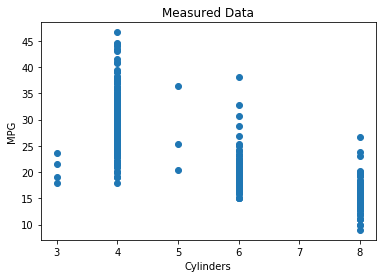

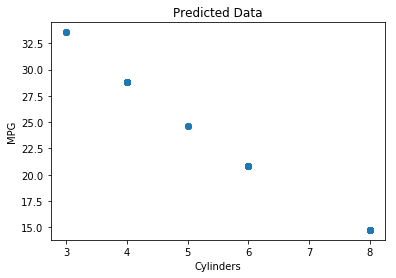

In [7]:
values = OLS_ind(x,1,2)
print(values)
value = R2YCalc_ind(values,x,1,2)
print(value)
dataPlot_ind(values,x,1,2)

[ 0.23829272 -0.97504205 -0.23829272]
-123.01460669699833


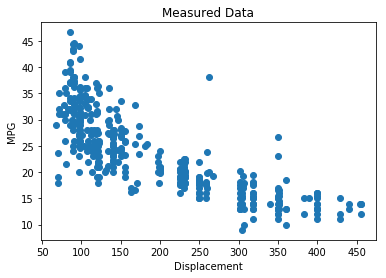

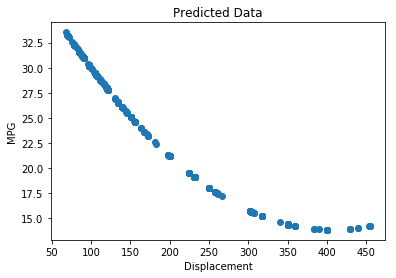

In [8]:
values = OLS_ind(x,2,2)
print(values)
value = R2YCalc_ind(values,x,2,2)
print(value)
dataPlot_ind(values,x,2,2)

[ 0.23209865 -1.03027113 -0.23209865]
-123.20439417678878


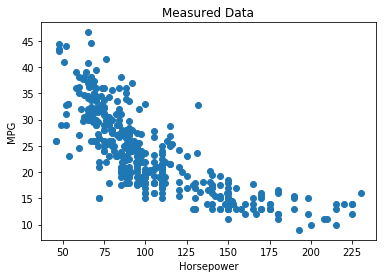

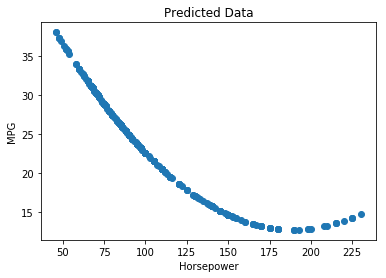

In [9]:
values = OLS_ind(x,3,2)
print(values)
value = R2YCalc_ind(values,x,3,2)
print(value)
dataPlot_ind(values,x,3,2)

[-0.01448768  0.02343629  0.18803504 -0.94421733 -0.16842705]
-112.41525054522813


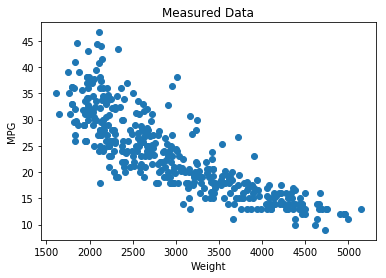

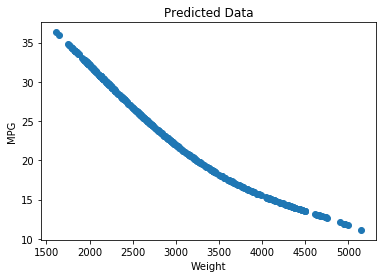

In [10]:
values = OLS_ind(x,4,4)
print(values)
value = R2YCalc_ind(values,x,4,4)
print(value)
dataPlot_ind(values,x,4,4)

[-0.08315361  0.44338275  0.08315361]
-320.3058693082295


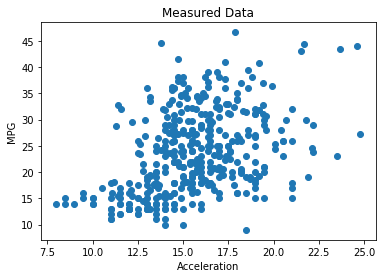

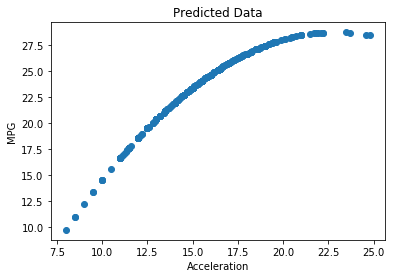

In [11]:
values = OLS_ind(x,5,2)
print(values)
value = R2YCalc_ind(values,x,5,2)
print(value)
dataPlot_ind(values,x,5,2)

The R2Y value is 0.6970374007227929


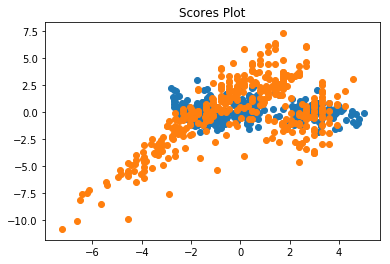

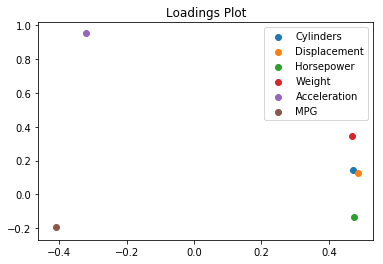

In [164]:
func_PLSR(x)

In [12]:
cylData = splitCylinder(x)

The R2Y value is 0.4011132529970357
The R2Y value is 0.26019590648230495
The R2Y value is 0.47564439241221934


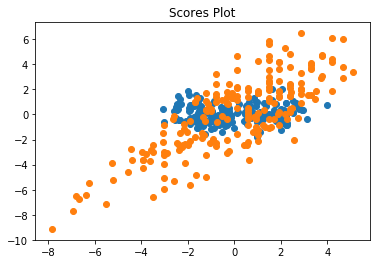

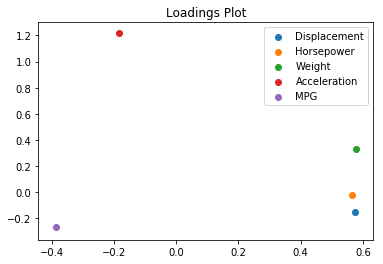

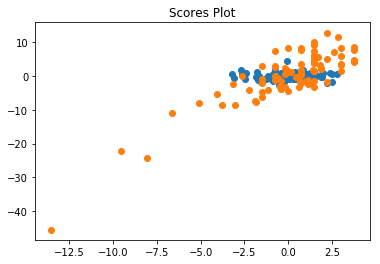

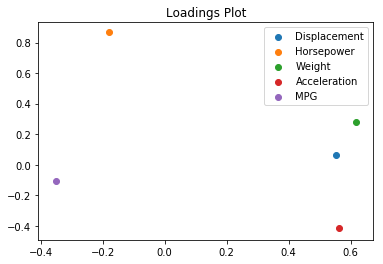

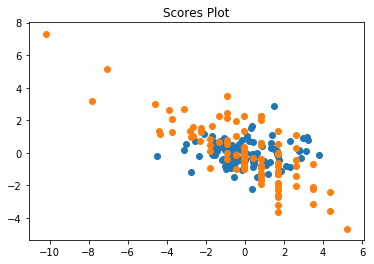

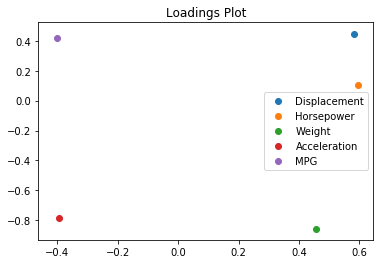

In [19]:
for i in range(3):
    cyl_PLSR(cylData[i])